In [1]:
import os
os.chdir("../..")

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from utils.dataset_loader import *
from utils.model_utils import *
from utils.train_utils import *
from utils.metrics import *
from utils.visualization import *
import optuna
import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

[INFO] Using device: cuda


In [4]:
os.makedirs("outputs/models", exist_ok=True)
os.makedirs("outputs/plots", exist_ok=True)

In [5]:
print("[INFO] Loading datasets...")
train_loader, val_loader, test_loader = load_datasets(
    "wildfire_dataset_scaled", batch_size=32, augmentation="augmented"
)
print("[INFO] Datasets loaded successfully!")

2024-12-21 21:39:55,293 - INFO - Loading datasets from wildfire_dataset_scaled with augmentation type 'augmented'.
2024-12-21 21:39:55,293 - INFO - Applying moderate augmentations: Flip, Rotate, and ColorJitter.
2024-12-21 21:39:55,302 - INFO - Initialized AlbumentationsDataset with root: wildfire_dataset_scaled/train
2024-12-21 21:39:55,304 - INFO - Initialized AlbumentationsDataset with root: wildfire_dataset_scaled/val
2024-12-21 21:39:55,306 - INFO - Initialized AlbumentationsDataset with root: wildfire_dataset_scaled/test
2024-12-21 21:39:55,306 - INFO - Datasets initialized. Preparing DataLoaders...
2024-12-21 21:39:55,307 - INFO - Using WeightedRandomSampler for class balancing.
2024-12-21 21:39:55,307 - INFO - Computing class weights from directory: wildfire_dataset_scaled/train
2024-12-21 21:39:55,308 - INFO - Class 'fire' has 730 samples.
2024-12-21 21:39:55,310 - INFO - Class 'nofire' has 1157 samples.
2024-12-21 21:39:55,312 - INFO - Computed class weights: {'fire': 2.58493

[INFO] Loading datasets...


2024-12-21 21:39:57,170 - INFO - DataLoaders created successfully.


[INFO] Datasets loaded successfully!


In [6]:
def objective(trial):
    print(f"[DEBUG] Starting trial {trial.number}...")

    # Hyperparameter suggestions
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "AdamW"])
    print(f"[DEBUG] Suggested hyperparameters: lr={lr}, weight_decay={weight_decay}, optimizer={optimizer_name}")

    # Initialize model
    print("[DEBUG] Initializing mobilenet_v2 model...")
    model = initialize_model("mobilenet_v2", num_classes=2, pretrained=True, freeze_all=False, unfreeze_last_n=4)
    model.to(device)

    # Optimizer setup
    print("[DEBUG] Setting up optimizer...")
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=3, factor=0.5)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Train the model
    print("[INFO] Starting model training...")
    save_path = "outputs/models/mobilenet_v2_trial_best.pth"
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        save_path=save_path,
        early_stop_patience=5,
        monitor_metric="val_recall",
    )
    print("[INFO] Training completed!")

    # Return validation recall
    val_recall = history["val_f1"][-1]
    print(f"[INFO] Trial {trial.number} - Final Validation val_f1: {val_recall:.4f}")
    return val_recall


In [7]:
# Run Optuna
print("[INFO] Running hyperparameter optimization...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
print(f"[INFO] Best parameters found: {study.best_params}")

[I 2024-12-21 21:39:57,195] A new study created in memory with name: no-name-8b757a7e-2977-4731-86f2-f8843d36ad3d


[INFO] Running hyperparameter optimization...
[DEBUG] Starting trial 0...
[DEBUG] Suggested hyperparameters: lr=7.454098860400718e-05, weight_decay=2.905414061276119e-05, optimizer=Adam
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000075
[INFO] Best model saved with val_recall: 0.8455
Epoch [1]: Train Loss: 0.5692, Train Acc: 0.7228 | Val Loss: 0.4533, Val Acc: 0.8159, Val Recall: 0.8455, Val F1: 0.8490


[INFO] Learning rate adjusted to: 0.000075
[INFO] Best model saved with val_recall: 0.9106
Epoch [2]: Train Loss: 0.3627, Train Acc: 0.8580 | Val Loss: 0.3212, Val Acc: 0.8731, Val Recall: 0.9106, Val F1: 0.8978


[INFO] Learning rate adjusted to: 0.000075
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [3]: Train Loss: 0.2325, Train Acc: 0.9157 | Val Loss: 0.2786, Val Acc: 0.8856, Val Recall: 0.8862, Val F1: 0.9046


[INFO] Learning rate adjusted to: 0.000075
[INFO] Best model saved with val_recall: 0.9146
Epoch [4]: Train Loss: 0.1845, Train Acc: 0.9274 | Val Loss: 0.2598, Val Acc: 0.8831, Val Recall: 0.9146, Val F1: 0.9054


[INFO] Learning rate adjusted to: 0.000037
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [5]: Train Loss: 0.1561, Train Acc: 0.9486 | Val Loss: 0.2348, Val Acc: 0.8905, Val Recall: 0.9106, Val F1: 0.9106


[INFO] Learning rate adjusted to: 0.000037
[INFO] Best model saved with val_recall: 0.9350
Epoch [6]: Train Loss: 0.1281, Train Acc: 0.9571 | Val Loss: 0.2359, Val Acc: 0.9055, Val Recall: 0.9350, Val F1: 0.9237


[INFO] Learning rate adjusted to: 0.000037
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [7]: Train Loss: 0.0960, Train Acc: 0.9714 | Val Loss: 0.2394, Val Acc: 0.9154, Val Recall: 0.9228, Val F1: 0.9303


[INFO] Learning rate adjusted to: 0.000037
[INFO] Best model saved with val_recall: 0.9390
Epoch [8]: Train Loss: 0.0990, Train Acc: 0.9698 | Val Loss: 0.2331, Val Acc: 0.9179, Val Recall: 0.9390, Val F1: 0.9333


[INFO] Learning rate adjusted to: 0.000019
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [9]: Train Loss: 0.0879, Train Acc: 0.9698 | Val Loss: 0.2382, Val Acc: 0.9154, Val Recall: 0.9390, Val F1: 0.9315


[INFO] Learning rate adjusted to: 0.000019
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [10]: Train Loss: 0.0843, Train Acc: 0.9709 | Val Loss: 0.2358, Val Acc: 0.9129, Val Recall: 0.9309, Val F1: 0.9290


[INFO] Learning rate adjusted to: 0.000019
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [11]: Train Loss: 0.0740, Train Acc: 0.9793 | Val Loss: 0.2370, Val Acc: 0.8980, Val Recall: 0.9065, Val F1: 0.9158


[INFO] Learning rate adjusted to: 0.000019
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [12]: Train Loss: 0.0654, Train Acc: 0.9820 | Val Loss: 0.2134, Val Acc: 0.9179, Val Recall: 0.9228, Val F1: 0.9322


[INFO] Learning rate adjusted to: 0.000009
[INFO] Best model saved with val_recall: 0.9472
Epoch [13]: Train Loss: 0.0660, Train Acc: 0.9783 | Val Loss: 0.2447, Val Acc: 0.9080, Val Recall: 0.9472, Val F1: 0.9264


[INFO] Learning rate adjusted to: 0.000009
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [14]: Train Loss: 0.0627, Train Acc: 0.9799 | Val Loss: 0.2367, Val Acc: 0.9229, Val Recall: 0.9390, Val F1: 0.9371


[INFO] Learning rate adjusted to: 0.000009
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [15]: Train Loss: 0.0515, Train Acc: 0.9873 | Val Loss: 0.2315, Val Acc: 0.9129, Val Recall: 0.9431, Val F1: 0.9299


[INFO] Learning rate adjusted to: 0.000009
[INFO] Best model saved with val_recall: 0.9593
Epoch [16]: Train Loss: 0.0472, Train Acc: 0.9857 | Val Loss: 0.2429, Val Acc: 0.9129, Val Recall: 0.9593, Val F1: 0.9310


[INFO] Learning rate adjusted to: 0.000005
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [17]: Train Loss: 0.0418, Train Acc: 0.9910 | Val Loss: 0.2240, Val Acc: 0.9104, Val Recall: 0.9390, Val F1: 0.9277


[INFO] Learning rate adjusted to: 0.000005
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [18]: Train Loss: 0.0447, Train Acc: 0.9899 | Val Loss: 0.2233, Val Acc: 0.9104, Val Recall: 0.9228, Val F1: 0.9265


[INFO] Learning rate adjusted to: 0.000005
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [19]: Train Loss: 0.0497, Train Acc: 0.9873 | Val Loss: 0.2443, Val Acc: 0.9179, Val Recall: 0.9512, Val F1: 0.9341


[INFO] Learning rate adjusted to: 0.000005
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [20]: Train Loss: 0.0443, Train Acc: 0.9910 | Val Loss: 0.2378, Val Acc: 0.9179, Val Recall: 0.9593, Val F1: 0.9347


[I 2024-12-21 21:44:06,816] Trial 0 finished with value: 0.937625754527163 and parameters: {'lr': 7.454098860400718e-05, 'weight_decay': 2.905414061276119e-05, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.937625754527163.


[INFO] Learning rate adjusted to: 0.000002
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [21]: Train Loss: 0.0446, Train Acc: 0.9889 | Val Loss: 0.2111, Val Acc: 0.9229, Val Recall: 0.9472, Val F1: 0.9376
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 21 epochs. Best val_recall: 0.9593

[INFO] Training completed!
[INFO] Trial 0 - Final Validation val_f1: 0.9376
[DEBUG] Starting trial 1...
[DEBUG] Suggested hyperparameters: lr=0.0002526515771755495, weight_decay=0.0002382069048014706, optimizer=SGD
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000253
[INFO] Best model saved with val_recall: 0.6504
Epoch [1]: Train Loss: 0.6907, Train Acc: 0.5310 | Val Loss: 0.6526, Val Acc: 0.6567, Val Recall: 0.6504, Val F1: 0.6987


[INFO] Learning rate adjusted to: 0.000253
[INFO] Best model saved with val_recall: 0.7846
Epoch [2]: Train Loss: 0.6267, Train Acc: 0.6720 | Val Loss: 0.6007, Val Acc: 0.7537, Val Recall: 0.7846, Val F1: 0.7959


[INFO] Learning rate adjusted to: 0.000253
[INFO] Best model saved with val_recall: 0.7927
Epoch [3]: Train Loss: 0.5751, Train Acc: 0.7382 | Val Loss: 0.5590, Val Acc: 0.7637, Val Recall: 0.7927, Val F1: 0.8041


[INFO] Learning rate adjusted to: 0.000253
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [4]: Train Loss: 0.5335, Train Acc: 0.7631 | Val Loss: 0.5349, Val Acc: 0.7736, Val Recall: 0.7846, Val F1: 0.8092


[INFO] Learning rate adjusted to: 0.000126
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [5]: Train Loss: 0.5094, Train Acc: 0.7769 | Val Loss: 0.5038, Val Acc: 0.7935, Val Recall: 0.7805, Val F1: 0.8223


[INFO] Learning rate adjusted to: 0.000126
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [6]: Train Loss: 0.4776, Train Acc: 0.8124 | Val Loss: 0.4893, Val Acc: 0.7836, Val Recall: 0.7846, Val F1: 0.8161


[INFO] Learning rate adjusted to: 0.000126
[INFO] Best model saved with val_recall: 0.8171
Epoch [7]: Train Loss: 0.4593, Train Acc: 0.8124 | Val Loss: 0.4747, Val Acc: 0.8085, Val Recall: 0.8171, Val F1: 0.8392


[INFO] Learning rate adjusted to: 0.000126
[INFO] Best model saved with val_recall: 0.8293
Epoch [8]: Train Loss: 0.4476, Train Acc: 0.8193 | Val Loss: 0.4508, Val Acc: 0.8134, Val Recall: 0.8293, Val F1: 0.8447


[INFO] Learning rate adjusted to: 0.000063
[INFO] Best model saved with val_recall: 0.8374
Epoch [9]: Train Loss: 0.4302, Train Acc: 0.8278 | Val Loss: 0.4486, Val Acc: 0.7811, Val Recall: 0.8374, Val F1: 0.8240


[INFO] Learning rate adjusted to: 0.000063
[INFO] Best model saved with val_recall: 0.8455
Epoch [10]: Train Loss: 0.4332, Train Acc: 0.8129 | Val Loss: 0.4401, Val Acc: 0.8259, Val Recall: 0.8455, Val F1: 0.8560


[INFO] Learning rate adjusted to: 0.000063
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [11]: Train Loss: 0.4296, Train Acc: 0.8188 | Val Loss: 0.4344, Val Acc: 0.8184, Val Recall: 0.8415, Val F1: 0.8501


[INFO] Learning rate adjusted to: 0.000063
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [12]: Train Loss: 0.4128, Train Acc: 0.8294 | Val Loss: 0.4300, Val Acc: 0.8209, Val Recall: 0.8130, Val F1: 0.8475


[INFO] Learning rate adjusted to: 0.000032
[INFO] Best model saved with val_recall: 0.8577
Epoch [13]: Train Loss: 0.4035, Train Acc: 0.8421 | Val Loss: 0.4219, Val Acc: 0.8209, Val Recall: 0.8577, Val F1: 0.8543


[INFO] Learning rate adjusted to: 0.000032
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [14]: Train Loss: 0.3979, Train Acc: 0.8357 | Val Loss: 0.4320, Val Acc: 0.8333, Val Recall: 0.8415, Val F1: 0.8607


[INFO] Learning rate adjusted to: 0.000032
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [15]: Train Loss: 0.4082, Train Acc: 0.8415 | Val Loss: 0.4196, Val Acc: 0.8259, Val Recall: 0.8496, Val F1: 0.8566


[INFO] Learning rate adjusted to: 0.000032
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [16]: Train Loss: 0.3989, Train Acc: 0.8325 | Val Loss: 0.4238, Val Acc: 0.8085, Val Recall: 0.8293, Val F1: 0.8412


[INFO] Learning rate adjusted to: 0.000016
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [17]: Train Loss: 0.3933, Train Acc: 0.8368 | Val Loss: 0.4159, Val Acc: 0.8184, Val Recall: 0.8537, Val F1: 0.8519


[I 2024-12-21 21:47:41,101] Trial 1 finished with value: 0.8530020703933747 and parameters: {'lr': 0.0002526515771755495, 'weight_decay': 0.0002382069048014706, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.937625754527163.


[INFO] Learning rate adjusted to: 0.000016
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [18]: Train Loss: 0.3960, Train Acc: 0.8347 | Val Loss: 0.4006, Val Acc: 0.8234, Val Recall: 0.8374, Val F1: 0.8530
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 18 epochs. Best val_recall: 0.8577

[INFO] Training completed!
[INFO] Trial 1 - Final Validation val_f1: 0.8530
[DEBUG] Starting trial 2...
[DEBUG] Suggested hyperparameters: lr=1.840441752819199e-05, weight_decay=1.1396985197235523e-05, optimizer=AdamW
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000018
[INFO] Best model saved with val_recall: 0.6138
Epoch [1]: Train Loss: 0.6680, Train Acc: 0.6025 | Val Loss: 0.6398, Val Acc: 0.6841, Val Recall: 0.6138, Val F1: 0.7040


[INFO] Learning rate adjusted to: 0.000018
[INFO] Best model saved with val_recall: 0.7276
Epoch [2]: Train Loss: 0.5913, Train Acc: 0.7356 | Val Loss: 0.5713, Val Acc: 0.7761, Val Recall: 0.7276, Val F1: 0.7991


[INFO] Learning rate adjusted to: 0.000018
[INFO] Best model saved with val_recall: 0.7927
Epoch [3]: Train Loss: 0.5218, Train Acc: 0.7965 | Val Loss: 0.5053, Val Acc: 0.7960, Val Recall: 0.7927, Val F1: 0.8263


[INFO] Learning rate adjusted to: 0.000018
[INFO] Best model saved with val_recall: 0.8455
Epoch [4]: Train Loss: 0.4422, Train Acc: 0.8373 | Val Loss: 0.4476, Val Acc: 0.8234, Val Recall: 0.8455, Val F1: 0.8542


[INFO] Learning rate adjusted to: 0.000009
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [5]: Train Loss: 0.3930, Train Acc: 0.8347 | Val Loss: 0.4150, Val Acc: 0.8383, Val Recall: 0.8374, Val F1: 0.8637


[INFO] Learning rate adjusted to: 0.000009
[INFO] Best model saved with val_recall: 0.8537
Epoch [6]: Train Loss: 0.3668, Train Acc: 0.8537 | Val Loss: 0.3944, Val Acc: 0.8532, Val Recall: 0.8537, Val F1: 0.8768


[INFO] Learning rate adjusted to: 0.000009
[INFO] Best model saved with val_recall: 0.8699
Epoch [7]: Train Loss: 0.3338, Train Acc: 0.8649 | Val Loss: 0.3679, Val Acc: 0.8433, Val Recall: 0.8699, Val F1: 0.8717


[INFO] Learning rate adjusted to: 0.000009
[INFO] Best model saved with val_recall: 0.8862
Epoch [8]: Train Loss: 0.3083, Train Acc: 0.8845 | Val Loss: 0.3520, Val Acc: 0.8557, Val Recall: 0.8862, Val F1: 0.8826


[INFO] Learning rate adjusted to: 0.000005
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [9]: Train Loss: 0.3010, Train Acc: 0.8824 | Val Loss: 0.3322, Val Acc: 0.8706, Val Recall: 0.8780, Val F1: 0.8926


[INFO] Learning rate adjusted to: 0.000005
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [10]: Train Loss: 0.2972, Train Acc: 0.8834 | Val Loss: 0.3433, Val Acc: 0.8507, Val Recall: 0.8740, Val F1: 0.8776


[INFO] Learning rate adjusted to: 0.000005
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [11]: Train Loss: 0.2744, Train Acc: 0.8924 | Val Loss: 0.3316, Val Acc: 0.8682, Val Recall: 0.8862, Val F1: 0.8916


[INFO] Learning rate adjusted to: 0.000005
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [12]: Train Loss: 0.2708, Train Acc: 0.8940 | Val Loss: 0.3291, Val Acc: 0.8632, Val Recall: 0.8862, Val F1: 0.8880


[INFO] Learning rate adjusted to: 0.000002
[INFO] Best model saved with val_recall: 0.9228
Epoch [13]: Train Loss: 0.2730, Train Acc: 0.8887 | Val Loss: 0.2991, Val Acc: 0.8856, Val Recall: 0.9228, Val F1: 0.9080


[INFO] Learning rate adjusted to: 0.000002
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [14]: Train Loss: 0.2463, Train Acc: 0.9184 | Val Loss: 0.3085, Val Acc: 0.8905, Val Recall: 0.9187, Val F1: 0.9113


[INFO] Learning rate adjusted to: 0.000002
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [15]: Train Loss: 0.2673, Train Acc: 0.8988 | Val Loss: 0.3116, Val Acc: 0.8706, Val Recall: 0.9024, Val F1: 0.8952


[INFO] Learning rate adjusted to: 0.000002
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [16]: Train Loss: 0.2486, Train Acc: 0.9094 | Val Loss: 0.3104, Val Acc: 0.8632, Val Recall: 0.8862, Val F1: 0.8880


[INFO] Learning rate adjusted to: 0.000001
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [17]: Train Loss: 0.2518, Train Acc: 0.8998 | Val Loss: 0.3014, Val Acc: 0.8731, Val Recall: 0.9187, Val F1: 0.8986


[I 2024-12-21 21:51:15,026] Trial 2 finished with value: 0.8961303462321792 and parameters: {'lr': 1.840441752819199e-05, 'weight_decay': 1.1396985197235523e-05, 'optimizer': 'AdamW'}. Best is trial 0 with value: 0.937625754527163.


[INFO] Learning rate adjusted to: 0.000001
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [18]: Train Loss: 0.2337, Train Acc: 0.9232 | Val Loss: 0.3088, Val Acc: 0.8731, Val Recall: 0.8943, Val F1: 0.8961
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 18 epochs. Best val_recall: 0.9228

[INFO] Training completed!
[INFO] Trial 2 - Final Validation val_f1: 0.8961
[DEBUG] Starting trial 3...
[DEBUG] Suggested hyperparameters: lr=0.001419749024715538, weight_decay=0.0009440755740372951, optimizer=AdamW
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.001420
[INFO] Best model saved with val_recall: 0.7398
Epoch [1]: Train Loss: 0.3443, Train Acc: 0.8532 | Val Loss: 0.9557, Val Acc: 0.7985, Val Recall: 0.7398, Val F1: 0.8180


[INFO] Learning rate adjusted to: 0.001420
[INFO] Best model saved with val_recall: 0.9634
Epoch [2]: Train Loss: 0.2429, Train Acc: 0.9094 | Val Loss: 0.3827, Val Acc: 0.8607, Val Recall: 0.9634, Val F1: 0.8943


[INFO] Learning rate adjusted to: 0.001420
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [3]: Train Loss: 0.2280, Train Acc: 0.9141 | Val Loss: 0.3905, Val Acc: 0.8706, Val Recall: 0.8862, Val F1: 0.8934


[INFO] Learning rate adjusted to: 0.001420
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [4]: Train Loss: 0.1920, Train Acc: 0.9210 | Val Loss: 0.2683, Val Acc: 0.9080, Val Recall: 0.9431, Val F1: 0.9261


[INFO] Learning rate adjusted to: 0.000710
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [5]: Train Loss: 0.1398, Train Acc: 0.9444 | Val Loss: 0.3935, Val Acc: 0.9005, Val Recall: 0.9024, Val F1: 0.9174


[INFO] Learning rate adjusted to: 0.000710
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [6]: Train Loss: 0.0937, Train Acc: 0.9693 | Val Loss: 0.3045, Val Acc: 0.8980, Val Recall: 0.9553, Val F1: 0.9198


[I 2024-12-21 21:52:37,727] Trial 3 finished with value: 0.9327902240325866 and parameters: {'lr': 0.001419749024715538, 'weight_decay': 0.0009440755740372951, 'optimizer': 'AdamW'}. Best is trial 0 with value: 0.937625754527163.


[INFO] Learning rate adjusted to: 0.000710
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [7]: Train Loss: 0.0760, Train Acc: 0.9735 | Val Loss: 0.2881, Val Acc: 0.9179, Val Recall: 0.9309, Val F1: 0.9328
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 7 epochs. Best val_recall: 0.9634

[INFO] Training completed!
[INFO] Trial 3 - Final Validation val_f1: 0.9328
[DEBUG] Starting trial 4...
[DEBUG] Suggested hyperparameters: lr=0.0012532928524559717, weight_decay=9.539789575775433e-05, optimizer=SGD
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.001253
[INFO] Best model saved with val_recall: 0.7073
Epoch [1]: Train Loss: 0.6104, Train Acc: 0.6820 | Val Loss: 0.5410, Val Acc: 0.7761, Val Recall: 0.7073, Val F1: 0.7945


[INFO] Learning rate adjusted to: 0.001253
[INFO] Best model saved with val_recall: 0.7805
Epoch [2]: Train Loss: 0.4525, Train Acc: 0.8023 | Val Loss: 0.4367, Val Acc: 0.8060, Val Recall: 0.7805, Val F1: 0.8312


[INFO] Learning rate adjusted to: 0.001253
[INFO] Best model saved with val_recall: 0.8618
Epoch [3]: Train Loss: 0.3543, Train Acc: 0.8516 | Val Loss: 0.3551, Val Acc: 0.8607, Val Recall: 0.8618, Val F1: 0.8833


[INFO] Learning rate adjusted to: 0.001253
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [4]: Train Loss: 0.3041, Train Acc: 0.8781 | Val Loss: 0.3650, Val Acc: 0.8532, Val Recall: 0.8455, Val F1: 0.8758


[INFO] Learning rate adjusted to: 0.000627
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [5]: Train Loss: 0.2913, Train Acc: 0.8771 | Val Loss: 0.3212, Val Acc: 0.8632, Val Recall: 0.8618, Val F1: 0.8852


[INFO] Learning rate adjusted to: 0.000627
[INFO] Best model saved with val_recall: 0.9106
Epoch [6]: Train Loss: 0.2156, Train Acc: 0.9141 | Val Loss: 0.2636, Val Acc: 0.9080, Val Recall: 0.9106, Val F1: 0.9237


[INFO] Learning rate adjusted to: 0.000627
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [7]: Train Loss: 0.2065, Train Acc: 0.9147 | Val Loss: 0.2455, Val Acc: 0.8856, Val Recall: 0.8984, Val F1: 0.9057


[INFO] Learning rate adjusted to: 0.000627
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [8]: Train Loss: 0.2016, Train Acc: 0.9221 | Val Loss: 0.2716, Val Acc: 0.8881, Val Recall: 0.8943, Val F1: 0.9072


[INFO] Learning rate adjusted to: 0.000313
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [9]: Train Loss: 0.1936, Train Acc: 0.9226 | Val Loss: 0.2568, Val Acc: 0.8955, Val Recall: 0.9106, Val F1: 0.9143


[INFO] Learning rate adjusted to: 0.000313
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [10]: Train Loss: 0.1762, Train Acc: 0.9322 | Val Loss: 0.2823, Val Acc: 0.8930, Val Recall: 0.9106, Val F1: 0.9124


[I 2024-12-21 21:54:47,883] Trial 4 finished with value: 0.925 and parameters: {'lr': 0.0012532928524559717, 'weight_decay': 9.539789575775433e-05, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.937625754527163.


[INFO] Learning rate adjusted to: 0.000313
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [11]: Train Loss: 0.1865, Train Acc: 0.9279 | Val Loss: 0.2485, Val Acc: 0.9104, Val Recall: 0.9024, Val F1: 0.9250
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 11 epochs. Best val_recall: 0.9106

[INFO] Training completed!
[INFO] Trial 4 - Final Validation val_f1: 0.9250
[DEBUG] Starting trial 5...
[DEBUG] Suggested hyperparameters: lr=0.00044300441780017997, weight_decay=0.0009587199213125971, optimizer=SGD
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000443
[INFO] Best model saved with val_recall: 0.6545
Epoch [1]: Train Loss: 0.6658, Train Acc: 0.5872 | Val Loss: 0.6366, Val Acc: 0.6965, Val Recall: 0.6545, Val F1: 0.7252


[INFO] Learning rate adjusted to: 0.000443
[INFO] Best model saved with val_recall: 0.8171
Epoch [2]: Train Loss: 0.5793, Train Acc: 0.7371 | Val Loss: 0.5476, Val Acc: 0.7736, Val Recall: 0.8171, Val F1: 0.8154


[INFO] Learning rate adjusted to: 0.000443
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [3]: Train Loss: 0.5164, Train Acc: 0.7875 | Val Loss: 0.5152, Val Acc: 0.7761, Val Recall: 0.8008, Val F1: 0.8140


[INFO] Learning rate adjusted to: 0.000443
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [4]: Train Loss: 0.4441, Train Acc: 0.8188 | Val Loss: 0.4731, Val Acc: 0.8010, Val Recall: 0.7967, Val F1: 0.8305


[INFO] Learning rate adjusted to: 0.000222
[INFO] Best model saved with val_recall: 0.8374
Epoch [5]: Train Loss: 0.4133, Train Acc: 0.8251 | Val Loss: 0.4293, Val Acc: 0.8209, Val Recall: 0.8374, Val F1: 0.8512


[INFO] Learning rate adjusted to: 0.000222
[INFO] Best model saved with val_recall: 0.8577
Epoch [6]: Train Loss: 0.3724, Train Acc: 0.8506 | Val Loss: 0.4186, Val Acc: 0.8209, Val Recall: 0.8577, Val F1: 0.8543


[INFO] Learning rate adjusted to: 0.000222
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [7]: Train Loss: 0.3692, Train Acc: 0.8500 | Val Loss: 0.4153, Val Acc: 0.8184, Val Recall: 0.8171, Val F1: 0.8463


[INFO] Learning rate adjusted to: 0.000222
[INFO] Best model saved with val_recall: 0.8659
Epoch [8]: Train Loss: 0.3675, Train Acc: 0.8479 | Val Loss: 0.3909, Val Acc: 0.8433, Val Recall: 0.8659, Val F1: 0.8712


[INFO] Learning rate adjusted to: 0.000111
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [9]: Train Loss: 0.3466, Train Acc: 0.8543 | Val Loss: 0.3743, Val Acc: 0.8333, Val Recall: 0.8415, Val F1: 0.8607


[INFO] Learning rate adjusted to: 0.000111
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [10]: Train Loss: 0.3227, Train Acc: 0.8680 | Val Loss: 0.3750, Val Acc: 0.8433, Val Recall: 0.8577, Val F1: 0.8701


[INFO] Learning rate adjusted to: 0.000111
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [11]: Train Loss: 0.3137, Train Acc: 0.8749 | Val Loss: 0.3752, Val Acc: 0.8308, Val Recall: 0.8618, Val F1: 0.8618


[INFO] Learning rate adjusted to: 0.000111
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [12]: Train Loss: 0.3245, Train Acc: 0.8622 | Val Loss: 0.3599, Val Acc: 0.8358, Val Recall: 0.8577, Val F1: 0.8648


[INFO] Learning rate adjusted to: 0.000055
[INFO] Best model saved with val_recall: 0.8821
Epoch [13]: Train Loss: 0.3224, Train Acc: 0.8590 | Val Loss: 0.3491, Val Acc: 0.8682, Val Recall: 0.8821, Val F1: 0.8912


[INFO] Learning rate adjusted to: 0.000055
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [14]: Train Loss: 0.3114, Train Acc: 0.8723 | Val Loss: 0.3601, Val Acc: 0.8507, Val Recall: 0.8537, Val F1: 0.8750


[INFO] Learning rate adjusted to: 0.000055
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [15]: Train Loss: 0.3038, Train Acc: 0.8771 | Val Loss: 0.3538, Val Acc: 0.8582, Val Recall: 0.8821, Val F1: 0.8839


[INFO] Learning rate adjusted to: 0.000055
[INFO] Best model saved with val_recall: 0.9065
Epoch [16]: Train Loss: 0.3142, Train Acc: 0.8659 | Val Loss: 0.3457, Val Acc: 0.8632, Val Recall: 0.9065, Val F1: 0.8902


[INFO] Learning rate adjusted to: 0.000028
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [17]: Train Loss: 0.3050, Train Acc: 0.8829 | Val Loss: 0.3542, Val Acc: 0.8433, Val Recall: 0.8699, Val F1: 0.8717


[INFO] Learning rate adjusted to: 0.000028
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [18]: Train Loss: 0.2889, Train Acc: 0.8850 | Val Loss: 0.3333, Val Acc: 0.8607, Val Recall: 0.8862, Val F1: 0.8862


[INFO] Learning rate adjusted to: 0.000028
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [19]: Train Loss: 0.2883, Train Acc: 0.8871 | Val Loss: 0.3457, Val Acc: 0.8582, Val Recall: 0.8740, Val F1: 0.8830


[INFO] Learning rate adjusted to: 0.000028
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [20]: Train Loss: 0.3023, Train Acc: 0.8771 | Val Loss: 0.3606, Val Acc: 0.8408, Val Recall: 0.8659, Val F1: 0.8694


[I 2024-12-21 21:58:57,601] Trial 5 finished with value: 0.8870967741935484 and parameters: {'lr': 0.00044300441780017997, 'weight_decay': 0.0009587199213125971, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.937625754527163.


[INFO] Learning rate adjusted to: 0.000014
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [21]: Train Loss: 0.2901, Train Acc: 0.8877 | Val Loss: 0.3213, Val Acc: 0.8607, Val Recall: 0.8943, Val F1: 0.8871
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 21 epochs. Best val_recall: 0.9065

[INFO] Training completed!
[INFO] Trial 5 - Final Validation val_f1: 0.8871
[DEBUG] Starting trial 6...
[DEBUG] Suggested hyperparameters: lr=0.007094361759669362, weight_decay=0.00012197384970109207, optimizer=Adam
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.007094
[INFO] Best model saved with val_recall: 0.6951
Epoch [1]: Train Loss: 0.6197, Train Acc: 0.6847 | Val Loss: 0.6309, Val Acc: 0.7189, Val Recall: 0.6951, Val F1: 0.7516


[INFO] Learning rate adjusted to: 0.007094
[INFO] Best model saved with val_recall: 0.9756
Epoch [2]: Train Loss: 0.5787, Train Acc: 0.7191 | Val Loss: 0.6391, Val Acc: 0.6443, Val Recall: 0.9756, Val F1: 0.7705


[INFO] Learning rate adjusted to: 0.007094
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [3]: Train Loss: 0.5925, Train Acc: 0.7234 | Val Loss: 1.0076, Val Acc: 0.6095, Val Recall: 0.4431, Val F1: 0.5813


[INFO] Learning rate adjusted to: 0.007094
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [4]: Train Loss: 0.4796, Train Acc: 0.7695 | Val Loss: 0.5585, Val Acc: 0.7214, Val Recall: 0.8089, Val F1: 0.7804


[INFO] Learning rate adjusted to: 0.007094
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [5]: Train Loss: 0.4952, Train Acc: 0.7605 | Val Loss: 0.4892, Val Acc: 0.7886, Val Recall: 0.7480, Val F1: 0.8124


[INFO] Learning rate adjusted to: 0.007094
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [6]: Train Loss: 0.3897, Train Acc: 0.8219 | Val Loss: 0.5929, Val Acc: 0.7189, Val Recall: 0.6138, Val F1: 0.7277


[I 2024-12-21 22:00:20,986] Trial 6 finished with value: 0.8219780219780219 and parameters: {'lr': 0.007094361759669362, 'weight_decay': 0.00012197384970109207, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.937625754527163.


[INFO] Learning rate adjusted to: 0.003547
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [7]: Train Loss: 0.4333, Train Acc: 0.8161 | Val Loss: 0.4703, Val Acc: 0.7985, Val Recall: 0.7602, Val F1: 0.8220
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 7 epochs. Best val_recall: 0.9756

[INFO] Training completed!
[INFO] Trial 6 - Final Validation val_f1: 0.8220
[DEBUG] Starting trial 7...
[DEBUG] Suggested hyperparameters: lr=0.00014861732037050007, weight_decay=0.00015553399226902494, optimizer=AdamW
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000149
[INFO] Best model saved with val_recall: 0.8577
Epoch [1]: Train Loss: 0.4729, Train Acc: 0.7870 | Val Loss: 0.3634, Val Acc: 0.8507, Val Recall: 0.8577, Val F1: 0.8755


[INFO] Learning rate adjusted to: 0.000149
[INFO] Best model saved with val_recall: 0.9309
Epoch [2]: Train Loss: 0.2095, Train Acc: 0.9189 | Val Loss: 0.2632, Val Acc: 0.9005, Val Recall: 0.9309, Val F1: 0.9197


[INFO] Learning rate adjusted to: 0.000149
[INFO] Best model saved with val_recall: 0.9512
Epoch [3]: Train Loss: 0.1363, Train Acc: 0.9507 | Val Loss: 0.2292, Val Acc: 0.9129, Val Recall: 0.9512, Val F1: 0.9304


[INFO] Learning rate adjusted to: 0.000149
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [4]: Train Loss: 0.1221, Train Acc: 0.9587 | Val Loss: 0.2349, Val Acc: 0.9104, Val Recall: 0.9309, Val F1: 0.9271


[INFO] Learning rate adjusted to: 0.000074
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [5]: Train Loss: 0.0838, Train Acc: 0.9719 | Val Loss: 0.2631, Val Acc: 0.9179, Val Recall: 0.9431, Val F1: 0.9336


[INFO] Learning rate adjusted to: 0.000074
[INFO] Best model saved with val_recall: 0.9675
Epoch [6]: Train Loss: 0.0578, Train Acc: 0.9799 | Val Loss: 0.2474, Val Acc: 0.9154, Val Recall: 0.9675, Val F1: 0.9333


[INFO] Learning rate adjusted to: 0.000074
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [7]: Train Loss: 0.0581, Train Acc: 0.9830 | Val Loss: 0.2611, Val Acc: 0.9154, Val Recall: 0.9268, Val F1: 0.9306


[INFO] Learning rate adjusted to: 0.000074
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [8]: Train Loss: 0.0517, Train Acc: 0.9804 | Val Loss: 0.2463, Val Acc: 0.9254, Val Recall: 0.9512, Val F1: 0.9398


[INFO] Learning rate adjusted to: 0.000037
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [9]: Train Loss: 0.0297, Train Acc: 0.9942 | Val Loss: 0.2511, Val Acc: 0.9229, Val Recall: 0.9431, Val F1: 0.9374


[INFO] Learning rate adjusted to: 0.000037
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [10]: Train Loss: 0.0396, Train Acc: 0.9868 | Val Loss: 0.2660, Val Acc: 0.9179, Val Recall: 0.9390, Val F1: 0.9333


[INFO] Learning rate adjusted to: 0.000037
[INFO] Best model saved with val_recall: 0.9756
Epoch [11]: Train Loss: 0.0272, Train Acc: 0.9931 | Val Loss: 0.2443, Val Acc: 0.9328, Val Recall: 0.9756, Val F1: 0.9467


[INFO] Learning rate adjusted to: 0.000037
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [12]: Train Loss: 0.0325, Train Acc: 0.9905 | Val Loss: 0.2488, Val Acc: 0.9254, Val Recall: 0.9593, Val F1: 0.9402


[INFO] Learning rate adjusted to: 0.000019
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [13]: Train Loss: 0.0322, Train Acc: 0.9910 | Val Loss: 0.2673, Val Acc: 0.9179, Val Recall: 0.9472, Val F1: 0.9339


[INFO] Learning rate adjusted to: 0.000019
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [14]: Train Loss: 0.0211, Train Acc: 0.9968 | Val Loss: 0.2423, Val Acc: 0.9204, Val Recall: 0.9512, Val F1: 0.9360


[INFO] Learning rate adjusted to: 0.000019
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [15]: Train Loss: 0.0232, Train Acc: 0.9947 | Val Loss: 0.2838, Val Acc: 0.9279, Val Recall: 0.9675, Val F1: 0.9426


[I 2024-12-21 22:03:31,619] Trial 7 finished with value: 0.9209486166007905 and parameters: {'lr': 0.00014861732037050007, 'weight_decay': 0.00015553399226902494, 'optimizer': 'AdamW'}. Best is trial 0 with value: 0.937625754527163.


[INFO] Learning rate adjusted to: 0.000019
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [16]: Train Loss: 0.0198, Train Acc: 0.9952 | Val Loss: 0.3000, Val Acc: 0.9005, Val Recall: 0.9472, Val F1: 0.9209
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 16 epochs. Best val_recall: 0.9756

[INFO] Training completed!
[INFO] Trial 7 - Final Validation val_f1: 0.9209
[DEBUG] Starting trial 8...
[DEBUG] Suggested hyperparameters: lr=0.0010611521165800808, weight_decay=0.0003076555552993903, optimizer=AdamW
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.001061
[INFO] Best model saved with val_recall: 0.9350
Epoch [1]: Train Loss: 0.3328, Train Acc: 0.8548 | Val Loss: 0.4741, Val Acc: 0.8209, Val Recall: 0.9350, Val F1: 0.8647


[INFO] Learning rate adjusted to: 0.001061
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [2]: Train Loss: 0.2232, Train Acc: 0.9157 | Val Loss: 0.3546, Val Acc: 0.8682, Val Recall: 0.9228, Val F1: 0.8955


[INFO] Learning rate adjusted to: 0.001061
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [3]: Train Loss: 0.1985, Train Acc: 0.9290 | Val Loss: 0.3058, Val Acc: 0.8856, Val Recall: 0.9187, Val F1: 0.9076


[INFO] Learning rate adjusted to: 0.001061
[INFO] Best model saved with val_recall: 0.9512
Epoch [4]: Train Loss: 0.1313, Train Acc: 0.9459 | Val Loss: 0.4323, Val Acc: 0.8806, Val Recall: 0.9512, Val F1: 0.9070


[INFO] Learning rate adjusted to: 0.000531
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [5]: Train Loss: 0.1236, Train Acc: 0.9581 | Val Loss: 0.3089, Val Acc: 0.9104, Val Recall: 0.9146, Val F1: 0.9259


[INFO] Learning rate adjusted to: 0.000531
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [6]: Train Loss: 0.0944, Train Acc: 0.9677 | Val Loss: 0.2605, Val Acc: 0.9080, Val Recall: 0.9472, Val F1: 0.9264


[INFO] Learning rate adjusted to: 0.000531
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [7]: Train Loss: 0.0644, Train Acc: 0.9788 | Val Loss: 0.2421, Val Acc: 0.9229, Val Recall: 0.9512, Val F1: 0.9379


[INFO] Learning rate adjusted to: 0.000531
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [8]: Train Loss: 0.0458, Train Acc: 0.9846 | Val Loss: 0.3080, Val Acc: 0.9104, Val Recall: 0.9309, Val F1: 0.9271


[I 2024-12-21 22:05:19,275] Trial 8 finished with value: 0.9378757515030061 and parameters: {'lr': 0.0010611521165800808, 'weight_decay': 0.0003076555552993903, 'optimizer': 'AdamW'}. Best is trial 8 with value: 0.9378757515030061.


[INFO] Learning rate adjusted to: 0.000265
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [9]: Train Loss: 0.0399, Train Acc: 0.9878 | Val Loss: 0.2897, Val Acc: 0.9229, Val Recall: 0.9512, Val F1: 0.9379
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 9 epochs. Best val_recall: 0.9512

[INFO] Training completed!
[INFO] Trial 8 - Final Validation val_f1: 0.9379
[DEBUG] Starting trial 9...
[DEBUG] Suggested hyperparameters: lr=0.00022517980255331487, weight_decay=5.540834623738165e-05, optimizer=Adam
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000225
[INFO] Best model saved with val_recall: 0.8862
Epoch [1]: Train Loss: 0.4024, Train Acc: 0.8166 | Val Loss: 0.3180, Val Acc: 0.8831, Val Recall: 0.8862, Val F1: 0.9027


[INFO] Learning rate adjusted to: 0.000225
[INFO] Best model saved with val_recall: 0.9512
Epoch [2]: Train Loss: 0.1650, Train Acc: 0.9348 | Val Loss: 0.2222, Val Acc: 0.9154, Val Recall: 0.9512, Val F1: 0.9323


[INFO] Learning rate adjusted to: 0.000225
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [3]: Train Loss: 0.1170, Train Acc: 0.9550 | Val Loss: 0.2983, Val Acc: 0.8881, Val Recall: 0.9512, Val F1: 0.9123


[INFO] Learning rate adjusted to: 0.000225
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [4]: Train Loss: 0.0909, Train Acc: 0.9682 | Val Loss: 0.2818, Val Acc: 0.9055, Val Recall: 0.9350, Val F1: 0.9237


[INFO] Learning rate adjusted to: 0.000113
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [5]: Train Loss: 0.0671, Train Acc: 0.9767 | Val Loss: 0.2765, Val Acc: 0.8980, Val Recall: 0.8984, Val F1: 0.9151


[INFO] Learning rate adjusted to: 0.000113
[INFO] Best model saved with val_recall: 0.9675
Epoch [6]: Train Loss: 0.0437, Train Acc: 0.9846 | Val Loss: 0.2387, Val Acc: 0.9104, Val Recall: 0.9675, Val F1: 0.9297


[INFO] Learning rate adjusted to: 0.000113
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [7]: Train Loss: 0.0405, Train Acc: 0.9868 | Val Loss: 0.2885, Val Acc: 0.9055, Val Recall: 0.9512, Val F1: 0.9249


[INFO] Learning rate adjusted to: 0.000113
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [8]: Train Loss: 0.0437, Train Acc: 0.9873 | Val Loss: 0.2985, Val Acc: 0.9154, Val Recall: 0.9268, Val F1: 0.9306


[INFO] Learning rate adjusted to: 0.000056
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [9]: Train Loss: 0.0305, Train Acc: 0.9931 | Val Loss: 0.2660, Val Acc: 0.9303, Val Recall: 0.9512, Val F1: 0.9435


[INFO] Learning rate adjusted to: 0.000056
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [10]: Train Loss: 0.0224, Train Acc: 0.9931 | Val Loss: 0.2598, Val Acc: 0.9254, Val Recall: 0.9431, Val F1: 0.9393


[I 2024-12-21 22:07:30,195] Trial 9 finished with value: 0.9274193548387096 and parameters: {'lr': 0.00022517980255331487, 'weight_decay': 5.540834623738165e-05, 'optimizer': 'Adam'}. Best is trial 8 with value: 0.9378757515030061.


[INFO] Learning rate adjusted to: 0.000056
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [11]: Train Loss: 0.0221, Train Acc: 0.9947 | Val Loss: 0.2727, Val Acc: 0.9104, Val Recall: 0.9350, Val F1: 0.9274
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 11 epochs. Best val_recall: 0.9675

[INFO] Training completed!
[INFO] Trial 9 - Final Validation val_f1: 0.9274
[DEBUG] Starting trial 10...
[DEBUG] Suggested hyperparameters: lr=0.003834960027434939, weight_decay=0.0003689052686160159, optimizer=AdamW
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.003835
[INFO] Best model saved with val_recall: 0.7927
Epoch [1]: Train Loss: 0.5292, Train Acc: 0.7864 | Val Loss: 0.5518, Val Acc: 0.8234, Val Recall: 0.7927, Val F1: 0.8460


[INFO] Learning rate adjusted to: 0.003835
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [2]: Train Loss: 0.3608, Train Acc: 0.8627 | Val Loss: 0.5010, Val Acc: 0.8134, Val Recall: 0.7846, Val F1: 0.8373


[INFO] Learning rate adjusted to: 0.003835
[INFO] Best model saved with val_recall: 0.8333
Epoch [3]: Train Loss: 0.3589, Train Acc: 0.8548 | Val Loss: 0.3537, Val Acc: 0.8483, Val Recall: 0.8333, Val F1: 0.8705


[INFO] Learning rate adjusted to: 0.003835
[INFO] Best model saved with val_recall: 0.9350
Epoch [4]: Train Loss: 0.2438, Train Acc: 0.9046 | Val Loss: 0.3185, Val Acc: 0.8781, Val Recall: 0.9350, Val F1: 0.9037


[INFO] Learning rate adjusted to: 0.001917
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [5]: Train Loss: 0.2454, Train Acc: 0.9057 | Val Loss: 0.4211, Val Acc: 0.8582, Val Recall: 0.8333, Val F1: 0.8779


[INFO] Learning rate adjusted to: 0.001917
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [6]: Train Loss: 0.1933, Train Acc: 0.9279 | Val Loss: 0.3694, Val Acc: 0.8557, Val Recall: 0.8130, Val F1: 0.8734


[INFO] Learning rate adjusted to: 0.001917
[INFO] Best model saved with val_recall: 0.9512
Epoch [7]: Train Loss: 0.1672, Train Acc: 0.9385 | Val Loss: 0.2915, Val Acc: 0.8955, Val Recall: 0.9512, Val F1: 0.9176


[INFO] Learning rate adjusted to: 0.001917
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [8]: Train Loss: 0.1660, Train Acc: 0.9406 | Val Loss: 0.3134, Val Acc: 0.8582, Val Recall: 0.8171, Val F1: 0.8758


[INFO] Learning rate adjusted to: 0.000959
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [9]: Train Loss: 0.1846, Train Acc: 0.9290 | Val Loss: 0.3313, Val Acc: 0.8831, Val Recall: 0.8780, Val F1: 0.9019


[INFO] Learning rate adjusted to: 0.000959
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [10]: Train Loss: 0.1276, Train Acc: 0.9512 | Val Loss: 0.2596, Val Acc: 0.9204, Val Recall: 0.9350, Val F1: 0.9350


[INFO] Learning rate adjusted to: 0.000959
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [11]: Train Loss: 0.0764, Train Acc: 0.9777 | Val Loss: 0.2886, Val Acc: 0.9104, Val Recall: 0.9390, Val F1: 0.9277


[I 2024-12-21 22:09:53,267] Trial 10 finished with value: 0.9101796407185628 and parameters: {'lr': 0.003834960027434939, 'weight_decay': 0.0003689052686160159, 'optimizer': 'AdamW'}. Best is trial 8 with value: 0.9378757515030061.


[INFO] Learning rate adjusted to: 0.000959
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [12]: Train Loss: 0.0909, Train Acc: 0.9666 | Val Loss: 0.3320, Val Acc: 0.8881, Val Recall: 0.9268, Val F1: 0.9102
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 12 epochs. Best val_recall: 0.9512

[INFO] Training completed!
[INFO] Trial 10 - Final Validation val_f1: 0.9102
[DEBUG] Starting trial 11...
[DEBUG] Suggested hyperparameters: lr=3.227435494637463e-05, weight_decay=2.535344539190593e-05, optimizer=Adam
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000032
[INFO] Best model saved with val_recall: 0.8618
Epoch [1]: Train Loss: 0.6417, Train Acc: 0.6328 | Val Loss: 0.5609, Val Acc: 0.7761, Val Recall: 0.8618, Val F1: 0.8249


[INFO] Learning rate adjusted to: 0.000032
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [2]: Train Loss: 0.5211, Train Acc: 0.7827 | Val Loss: 0.4785, Val Acc: 0.7960, Val Recall: 0.8130, Val F1: 0.8299


[INFO] Learning rate adjusted to: 0.000032
[INFO] Best model saved with val_recall: 0.9024
Epoch [3]: Train Loss: 0.4129, Train Acc: 0.8453 | Val Loss: 0.3826, Val Acc: 0.8532, Val Recall: 0.9024, Val F1: 0.8827


[INFO] Learning rate adjusted to: 0.000032
[INFO] Best model saved with val_recall: 0.9065
Epoch [4]: Train Loss: 0.3289, Train Acc: 0.8813 | Val Loss: 0.3321, Val Acc: 0.8706, Val Recall: 0.9065, Val F1: 0.8956


[INFO] Learning rate adjusted to: 0.000016
[INFO] Best model saved with val_recall: 0.9512
Epoch [5]: Train Loss: 0.2739, Train Acc: 0.8961 | Val Loss: 0.2966, Val Acc: 0.8930, Val Recall: 0.9512, Val F1: 0.9159


[INFO] Learning rate adjusted to: 0.000016
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [6]: Train Loss: 0.2393, Train Acc: 0.9157 | Val Loss: 0.2874, Val Acc: 0.8831, Val Recall: 0.9065, Val F1: 0.9047


[INFO] Learning rate adjusted to: 0.000016
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [7]: Train Loss: 0.2319, Train Acc: 0.9200 | Val Loss: 0.2707, Val Acc: 0.8980, Val Recall: 0.9146, Val F1: 0.9165


[INFO] Learning rate adjusted to: 0.000016
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [8]: Train Loss: 0.2189, Train Acc: 0.9173 | Val Loss: 0.2687, Val Acc: 0.8856, Val Recall: 0.9187, Val F1: 0.9076


[INFO] Learning rate adjusted to: 0.000008
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [9]: Train Loss: 0.1961, Train Acc: 0.9279 | Val Loss: 0.2771, Val Acc: 0.8831, Val Recall: 0.9065, Val F1: 0.9047


[I 2024-12-21 22:11:52,514] Trial 11 finished with value: 0.9105367793240556 and parameters: {'lr': 3.227435494637463e-05, 'weight_decay': 2.535344539190593e-05, 'optimizer': 'Adam'}. Best is trial 8 with value: 0.9378757515030061.


[INFO] Learning rate adjusted to: 0.000008
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [10]: Train Loss: 0.1914, Train Acc: 0.9300 | Val Loss: 0.2668, Val Acc: 0.8881, Val Recall: 0.9309, Val F1: 0.9105
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 10 epochs. Best val_recall: 0.9512

[INFO] Training completed!
[INFO] Trial 11 - Final Validation val_f1: 0.9105
[DEBUG] Starting trial 12...
[DEBUG] Suggested hyperparameters: lr=9.443361931840993e-05, weight_decay=4.18010397423944e-05, optimizer=Adam
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000094
[INFO] Best model saved with val_recall: 0.8211
Epoch [1]: Train Loss: 0.5418, Train Acc: 0.7451 | Val Loss: 0.4247, Val Acc: 0.8358, Val Recall: 0.8211, Val F1: 0.8596


[INFO] Learning rate adjusted to: 0.000094
[INFO] Best model saved with val_recall: 0.8902
Epoch [2]: Train Loss: 0.2978, Train Acc: 0.8861 | Val Loss: 0.3327, Val Acc: 0.8657, Val Recall: 0.8902, Val F1: 0.8902


[INFO] Learning rate adjusted to: 0.000094
[INFO] Best model saved with val_recall: 0.9390
Epoch [3]: Train Loss: 0.2046, Train Acc: 0.9237 | Val Loss: 0.2629, Val Acc: 0.8881, Val Recall: 0.9390, Val F1: 0.9112


[INFO] Learning rate adjusted to: 0.000094
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [4]: Train Loss: 0.1621, Train Acc: 0.9380 | Val Loss: 0.2310, Val Acc: 0.9104, Val Recall: 0.9228, Val F1: 0.9265


[INFO] Learning rate adjusted to: 0.000047
[INFO] Best model saved with val_recall: 0.9431
Epoch [5]: Train Loss: 0.1178, Train Acc: 0.9613 | Val Loss: 0.2110, Val Acc: 0.9254, Val Recall: 0.9431, Val F1: 0.9393


[INFO] Learning rate adjusted to: 0.000047
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [6]: Train Loss: 0.0861, Train Acc: 0.9730 | Val Loss: 0.2453, Val Acc: 0.9179, Val Recall: 0.9187, Val F1: 0.9320


[INFO] Learning rate adjusted to: 0.000047
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [7]: Train Loss: 0.0778, Train Acc: 0.9777 | Val Loss: 0.2322, Val Acc: 0.9179, Val Recall: 0.9390, Val F1: 0.9333


[INFO] Learning rate adjusted to: 0.000047
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [8]: Train Loss: 0.0679, Train Acc: 0.9788 | Val Loss: 0.2279, Val Acc: 0.9229, Val Recall: 0.9390, Val F1: 0.9371


[INFO] Learning rate adjusted to: 0.000024
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [9]: Train Loss: 0.0664, Train Acc: 0.9793 | Val Loss: 0.2524, Val Acc: 0.9030, Val Recall: 0.9431, Val F1: 0.9225


[INFO] Learning rate adjusted to: 0.000024
[INFO] Best model saved with val_recall: 0.9593
Epoch [10]: Train Loss: 0.0610, Train Acc: 0.9841 | Val Loss: 0.2317, Val Acc: 0.9279, Val Recall: 0.9593, Val F1: 0.9421


[INFO] Learning rate adjusted to: 0.000024
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [11]: Train Loss: 0.0517, Train Acc: 0.9878 | Val Loss: 0.2435, Val Acc: 0.9154, Val Recall: 0.9431, Val F1: 0.9317


[INFO] Learning rate adjusted to: 0.000024
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [12]: Train Loss: 0.0569, Train Acc: 0.9809 | Val Loss: 0.2388, Val Acc: 0.9303, Val Recall: 0.9593, Val F1: 0.9440


[INFO] Learning rate adjusted to: 0.000012
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [13]: Train Loss: 0.0505, Train Acc: 0.9846 | Val Loss: 0.2409, Val Acc: 0.9129, Val Recall: 0.9472, Val F1: 0.9301


[INFO] Learning rate adjusted to: 0.000012
[INFO] Best model saved with val_recall: 0.9675
Epoch [14]: Train Loss: 0.0415, Train Acc: 0.9921 | Val Loss: 0.2183, Val Acc: 0.9204, Val Recall: 0.9675, Val F1: 0.9370


[INFO] Learning rate adjusted to: 0.000012
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [15]: Train Loss: 0.0373, Train Acc: 0.9894 | Val Loss: 0.2432, Val Acc: 0.9154, Val Recall: 0.9390, Val F1: 0.9315


[INFO] Learning rate adjusted to: 0.000012
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [16]: Train Loss: 0.0434, Train Acc: 0.9857 | Val Loss: 0.2301, Val Acc: 0.9328, Val Recall: 0.9512, Val F1: 0.9455


[INFO] Learning rate adjusted to: 0.000006
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [17]: Train Loss: 0.0338, Train Acc: 0.9931 | Val Loss: 0.2422, Val Acc: 0.9279, Val Recall: 0.9634, Val F1: 0.9423


[INFO] Learning rate adjusted to: 0.000006
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [18]: Train Loss: 0.0348, Train Acc: 0.9921 | Val Loss: 0.2361, Val Acc: 0.9229, Val Recall: 0.9634, Val F1: 0.9386


[I 2024-12-21 22:15:39,993] Trial 12 finished with value: 0.948 and parameters: {'lr': 9.443361931840993e-05, 'weight_decay': 4.18010397423944e-05, 'optimizer': 'Adam'}. Best is trial 12 with value: 0.948.


[INFO] Learning rate adjusted to: 0.000006
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [19]: Train Loss: 0.0298, Train Acc: 0.9921 | Val Loss: 0.2198, Val Acc: 0.9353, Val Recall: 0.9634, Val F1: 0.9480
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 19 epochs. Best val_recall: 0.9675

[INFO] Training completed!
[INFO] Trial 12 - Final Validation val_f1: 0.9480
[DEBUG] Starting trial 13...
[DEBUG] Suggested hyperparameters: lr=0.0007549673375733412, weight_decay=0.0004581499411595335, optimizer=Adam
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000755
[INFO] Best model saved with val_recall: 0.8902
Epoch [1]: Train Loss: 0.2899, Train Acc: 0.8691 | Val Loss: 0.3637, Val Acc: 0.8458, Val Recall: 0.8902, Val F1: 0.8760


[INFO] Learning rate adjusted to: 0.000755
[INFO] Best model saved with val_recall: 0.9024
Epoch [2]: Train Loss: 0.1798, Train Acc: 0.9348 | Val Loss: 0.4407, Val Acc: 0.8657, Val Recall: 0.9024, Val F1: 0.8916


[INFO] Learning rate adjusted to: 0.000755
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [3]: Train Loss: 0.1827, Train Acc: 0.9322 | Val Loss: 0.2538, Val Acc: 0.8930, Val Recall: 0.8984, Val F1: 0.9113


[INFO] Learning rate adjusted to: 0.000755
[INFO] Best model saved with val_recall: 0.9512
Epoch [4]: Train Loss: 0.1215, Train Acc: 0.9523 | Val Loss: 0.3532, Val Acc: 0.8980, Val Recall: 0.9512, Val F1: 0.9194


[INFO] Learning rate adjusted to: 0.000755
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [5]: Train Loss: 0.1095, Train Acc: 0.9618 | Val Loss: 0.2884, Val Acc: 0.8856, Val Recall: 0.9390, Val F1: 0.9094


[INFO] Learning rate adjusted to: 0.000377
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [6]: Train Loss: 0.1122, Train Acc: 0.9597 | Val Loss: 0.2655, Val Acc: 0.9129, Val Recall: 0.9431, Val F1: 0.9299


[INFO] Learning rate adjusted to: 0.000377
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [7]: Train Loss: 0.0690, Train Acc: 0.9777 | Val Loss: 0.2468, Val Acc: 0.9104, Val Recall: 0.9228, Val F1: 0.9265


[INFO] Learning rate adjusted to: 0.000377
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [8]: Train Loss: 0.0319, Train Acc: 0.9910 | Val Loss: 0.2869, Val Acc: 0.9129, Val Recall: 0.9350, Val F1: 0.9293


[INFO] Learning rate adjusted to: 0.000377
[INFO] Best model saved with val_recall: 0.9553
Epoch [9]: Train Loss: 0.0422, Train Acc: 0.9804 | Val Loss: 0.2866, Val Acc: 0.9129, Val Recall: 0.9553, Val F1: 0.9307


[INFO] Learning rate adjusted to: 0.000189
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [10]: Train Loss: 0.0336, Train Acc: 0.9899 | Val Loss: 0.3759, Val Acc: 0.9055, Val Recall: 0.9268, Val F1: 0.9231


[INFO] Learning rate adjusted to: 0.000189
[INFO] Best model saved with val_recall: 0.9593
Epoch [11]: Train Loss: 0.0359, Train Acc: 0.9883 | Val Loss: 0.3810, Val Acc: 0.9179, Val Recall: 0.9593, Val F1: 0.9347


[INFO] Learning rate adjusted to: 0.000189
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [12]: Train Loss: 0.0140, Train Acc: 0.9968 | Val Loss: 0.3831, Val Acc: 0.9080, Val Recall: 0.9309, Val F1: 0.9253


[INFO] Learning rate adjusted to: 0.000189
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [13]: Train Loss: 0.0151, Train Acc: 0.9958 | Val Loss: 0.3493, Val Acc: 0.9055, Val Recall: 0.9512, Val F1: 0.9249


[INFO] Learning rate adjusted to: 0.000094
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [14]: Train Loss: 0.0128, Train Acc: 0.9974 | Val Loss: 0.3846, Val Acc: 0.9129, Val Recall: 0.9431, Val F1: 0.9299


[INFO] Learning rate adjusted to: 0.000094
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [15]: Train Loss: 0.0147, Train Acc: 0.9952 | Val Loss: 0.3803, Val Acc: 0.9154, Val Recall: 0.9350, Val F1: 0.9312


[I 2024-12-21 22:18:50,594] Trial 13 finished with value: 0.9218436873747495 and parameters: {'lr': 0.0007549673375733412, 'weight_decay': 0.0004581499411595335, 'optimizer': 'Adam'}. Best is trial 12 with value: 0.948.


[INFO] Learning rate adjusted to: 0.000094
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [16]: Train Loss: 0.0104, Train Acc: 0.9968 | Val Loss: 0.3687, Val Acc: 0.9030, Val Recall: 0.9350, Val F1: 0.9218
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 16 epochs. Best val_recall: 0.9593

[INFO] Training completed!
[INFO] Trial 13 - Final Validation val_f1: 0.9218
[DEBUG] Starting trial 14...
[DEBUG] Suggested hyperparameters: lr=8.082544136021477e-05, weight_decay=5.473963606408351e-05, optimizer=AdamW
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000081
[INFO] Best model saved with val_recall: 0.8130
Epoch [1]: Train Loss: 0.5822, Train Acc: 0.7101 | Val Loss: 0.4704, Val Acc: 0.8159, Val Recall: 0.8130, Val F1: 0.8439


[INFO] Learning rate adjusted to: 0.000081
[INFO] Best model saved with val_recall: 0.8862
Epoch [2]: Train Loss: 0.3427, Train Acc: 0.8670 | Val Loss: 0.3276, Val Acc: 0.8806, Val Recall: 0.8862, Val F1: 0.9008


[INFO] Learning rate adjusted to: 0.000081
[INFO] Best model saved with val_recall: 0.9146
Epoch [3]: Train Loss: 0.2274, Train Acc: 0.9184 | Val Loss: 0.2960, Val Acc: 0.8856, Val Recall: 0.9146, Val F1: 0.9073


[INFO] Learning rate adjusted to: 0.000081
[INFO] Best model saved with val_recall: 0.9309
Epoch [4]: Train Loss: 0.1706, Train Acc: 0.9417 | Val Loss: 0.2292, Val Acc: 0.9080, Val Recall: 0.9309, Val F1: 0.9253


[INFO] Learning rate adjusted to: 0.000040
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [5]: Train Loss: 0.1158, Train Acc: 0.9608 | Val Loss: 0.2597, Val Acc: 0.9055, Val Recall: 0.9106, Val F1: 0.9218


[INFO] Learning rate adjusted to: 0.000040
[INFO] Best model saved with val_recall: 0.9553
Epoch [6]: Train Loss: 0.1129, Train Acc: 0.9581 | Val Loss: 0.2185, Val Acc: 0.9254, Val Recall: 0.9553, Val F1: 0.9400


[INFO] Learning rate adjusted to: 0.000040
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [7]: Train Loss: 0.0973, Train Acc: 0.9661 | Val Loss: 0.2305, Val Acc: 0.9179, Val Recall: 0.9390, Val F1: 0.9333


[INFO] Learning rate adjusted to: 0.000040
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [8]: Train Loss: 0.0835, Train Acc: 0.9682 | Val Loss: 0.2356, Val Acc: 0.9080, Val Recall: 0.9268, Val F1: 0.9249


[INFO] Learning rate adjusted to: 0.000020
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [9]: Train Loss: 0.0651, Train Acc: 0.9815 | Val Loss: 0.2463, Val Acc: 0.9055, Val Recall: 0.9309, Val F1: 0.9234


[INFO] Learning rate adjusted to: 0.000020
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [10]: Train Loss: 0.0720, Train Acc: 0.9772 | Val Loss: 0.2309, Val Acc: 0.9104, Val Recall: 0.9390, Val F1: 0.9277


[I 2024-12-21 22:21:01,789] Trial 14 finished with value: 0.9378757515030061 and parameters: {'lr': 8.082544136021477e-05, 'weight_decay': 5.473963606408351e-05, 'optimizer': 'AdamW'}. Best is trial 12 with value: 0.948.


[INFO] Learning rate adjusted to: 0.000020
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [11]: Train Loss: 0.0545, Train Acc: 0.9862 | Val Loss: 0.2015, Val Acc: 0.9229, Val Recall: 0.9512, Val F1: 0.9379
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 11 epochs. Best val_recall: 0.9553

[INFO] Training completed!
[INFO] Trial 14 - Final Validation val_f1: 0.9379
[DEBUG] Starting trial 15...
[DEBUG] Suggested hyperparameters: lr=1.1066979927160872e-05, weight_decay=1.0703659915339561e-05, optimizer=Adam
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000011
[INFO] Best model saved with val_recall: 0.6789
Epoch [1]: Train Loss: 0.6905, Train Acc: 0.5390 | Val Loss: 0.6601, Val Acc: 0.6617, Val Recall: 0.6789, Val F1: 0.7106


[INFO] Learning rate adjusted to: 0.000011
[INFO] Best model saved with val_recall: 0.6951
Epoch [2]: Train Loss: 0.6458, Train Acc: 0.6391 | Val Loss: 0.6296, Val Acc: 0.7164, Val Recall: 0.6951, Val F1: 0.7500


[INFO] Learning rate adjusted to: 0.000011
[INFO] Best model saved with val_recall: 0.7886
Epoch [3]: Train Loss: 0.6138, Train Acc: 0.7138 | Val Loss: 0.5872, Val Acc: 0.7836, Val Recall: 0.7886, Val F1: 0.8168


[INFO] Learning rate adjusted to: 0.000011
[INFO] Best model saved with val_recall: 0.7927
Epoch [4]: Train Loss: 0.5637, Train Acc: 0.7716 | Val Loss: 0.5531, Val Acc: 0.7886, Val Recall: 0.7927, Val F1: 0.8211


[INFO] Learning rate adjusted to: 0.000006
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [5]: Train Loss: 0.5190, Train Acc: 0.8071 | Val Loss: 0.5141, Val Acc: 0.8060, Val Recall: 0.7764, Val F1: 0.8304


[INFO] Learning rate adjusted to: 0.000006
[INFO] Best model saved with val_recall: 0.8333
Epoch [6]: Train Loss: 0.4864, Train Acc: 0.8156 | Val Loss: 0.4904, Val Acc: 0.8109, Val Recall: 0.8333, Val F1: 0.8436


[INFO] Learning rate adjusted to: 0.000006
[INFO] Best model saved with val_recall: 0.8374
Epoch [7]: Train Loss: 0.4548, Train Acc: 0.8426 | Val Loss: 0.4762, Val Acc: 0.8085, Val Recall: 0.8374, Val F1: 0.8425


[INFO] Learning rate adjusted to: 0.000006
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [8]: Train Loss: 0.4490, Train Acc: 0.8272 | Val Loss: 0.4655, Val Acc: 0.8085, Val Recall: 0.8293, Val F1: 0.8412


[INFO] Learning rate adjusted to: 0.000003
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [9]: Train Loss: 0.4203, Train Acc: 0.8421 | Val Loss: 0.4415, Val Acc: 0.8234, Val Recall: 0.8293, Val F1: 0.8518


[INFO] Learning rate adjusted to: 0.000003
[INFO] Best model saved with val_recall: 0.8455
Epoch [10]: Train Loss: 0.4098, Train Acc: 0.8447 | Val Loss: 0.4376, Val Acc: 0.8134, Val Recall: 0.8455, Val F1: 0.8473


[INFO] Learning rate adjusted to: 0.000003
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [11]: Train Loss: 0.4048, Train Acc: 0.8548 | Val Loss: 0.4365, Val Acc: 0.8259, Val Recall: 0.8211, Val F1: 0.8523


[INFO] Learning rate adjusted to: 0.000003
[INFO] Best model saved with val_recall: 0.8740
Epoch [12]: Train Loss: 0.3979, Train Acc: 0.8442 | Val Loss: 0.4206, Val Acc: 0.8433, Val Recall: 0.8740, Val F1: 0.8722


[INFO] Learning rate adjusted to: 0.000001
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [13]: Train Loss: 0.3998, Train Acc: 0.8352 | Val Loss: 0.4142, Val Acc: 0.8458, Val Recall: 0.8740, Val F1: 0.8740


[INFO] Learning rate adjusted to: 0.000001
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [14]: Train Loss: 0.3808, Train Acc: 0.8532 | Val Loss: 0.4106, Val Acc: 0.8308, Val Recall: 0.8415, Val F1: 0.8589


[INFO] Learning rate adjusted to: 0.000001
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [15]: Train Loss: 0.3895, Train Acc: 0.8368 | Val Loss: 0.4171, Val Acc: 0.8408, Val Recall: 0.8659, Val F1: 0.8694


[INFO] Learning rate adjusted to: 0.000001
[INFO] Best model saved with val_recall: 0.8780
Epoch [16]: Train Loss: 0.3710, Train Acc: 0.8574 | Val Loss: 0.4022, Val Acc: 0.8532, Val Recall: 0.8780, Val F1: 0.8798


[INFO] Learning rate adjusted to: 0.000001
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [17]: Train Loss: 0.3769, Train Acc: 0.8585 | Val Loss: 0.4071, Val Acc: 0.8209, Val Recall: 0.8659, Val F1: 0.8554


[INFO] Learning rate adjusted to: 0.000001
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [18]: Train Loss: 0.3803, Train Acc: 0.8484 | Val Loss: 0.3956, Val Acc: 0.8507, Val Recall: 0.8659, Val F1: 0.8765


[INFO] Learning rate adjusted to: 0.000001
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [19]: Train Loss: 0.3717, Train Acc: 0.8553 | Val Loss: 0.3983, Val Acc: 0.8483, Val Recall: 0.8618, Val F1: 0.8742


[INFO] Learning rate adjusted to: 0.000001
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [20]: Train Loss: 0.3659, Train Acc: 0.8680 | Val Loss: 0.3955, Val Acc: 0.8383, Val Recall: 0.8618, Val F1: 0.8671


[I 2024-12-21 22:25:13,760] Trial 15 finished with value: 0.865424430641822 and parameters: {'lr': 1.1066979927160872e-05, 'weight_decay': 1.0703659915339561e-05, 'optimizer': 'Adam'}. Best is trial 12 with value: 0.948.


[INFO] Learning rate adjusted to: 0.000000
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [21]: Train Loss: 0.3649, Train Acc: 0.8596 | Val Loss: 0.3982, Val Acc: 0.8383, Val Recall: 0.8496, Val F1: 0.8654
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 21 epochs. Best val_recall: 0.8780

[INFO] Training completed!
[INFO] Trial 15 - Final Validation val_f1: 0.8654
[DEBUG] Starting trial 16...
[DEBUG] Suggested hyperparameters: lr=0.0024238801176501394, weight_decay=5.668899153737781e-05, optimizer=AdamW
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.002424
[INFO] Best model saved with val_recall: 0.7927
Epoch [1]: Train Loss: 0.4203, Train Acc: 0.8219 | Val Loss: 0.5029, Val Acc: 0.8308, Val Recall: 0.7927, Val F1: 0.8515


[INFO] Learning rate adjusted to: 0.002424
[INFO] Best model saved with val_recall: 0.8049
Epoch [2]: Train Loss: 0.2853, Train Acc: 0.8855 | Val Loss: 0.5134, Val Acc: 0.8134, Val Recall: 0.8049, Val F1: 0.8408


[INFO] Learning rate adjusted to: 0.002424
[INFO] Best model saved with val_recall: 0.8374
Epoch [3]: Train Loss: 0.2834, Train Acc: 0.8945 | Val Loss: 0.4007, Val Acc: 0.8532, Val Recall: 0.8374, Val F1: 0.8747


[INFO] Learning rate adjusted to: 0.002424
[INFO] Best model saved with val_recall: 0.9431
Epoch [4]: Train Loss: 0.2259, Train Acc: 0.9062 | Val Loss: 0.2754, Val Acc: 0.8930, Val Recall: 0.9431, Val F1: 0.9152


[INFO] Learning rate adjusted to: 0.002424
[INFO] Best model saved with val_recall: 0.9512
Epoch [5]: Train Loss: 0.1871, Train Acc: 0.9306 | Val Loss: 0.3874, Val Acc: 0.8706, Val Recall: 0.9512, Val F1: 0.9000


[INFO] Learning rate adjusted to: 0.001212
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [6]: Train Loss: 0.1983, Train Acc: 0.9226 | Val Loss: 0.4310, Val Acc: 0.8557, Val Recall: 0.8333, Val F1: 0.8761


[INFO] Learning rate adjusted to: 0.001212
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [7]: Train Loss: 0.1466, Train Acc: 0.9433 | Val Loss: 0.2404, Val Acc: 0.8980, Val Recall: 0.9431, Val F1: 0.9188


[INFO] Learning rate adjusted to: 0.001212
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [8]: Train Loss: 0.1105, Train Acc: 0.9565 | Val Loss: 0.3014, Val Acc: 0.8905, Val Recall: 0.9228, Val F1: 0.9116


[INFO] Learning rate adjusted to: 0.001212
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [9]: Train Loss: 0.1073, Train Acc: 0.9618 | Val Loss: 0.2270, Val Acc: 0.9030, Val Recall: 0.9431, Val F1: 0.9225


[I 2024-12-21 22:27:13,257] Trial 16 finished with value: 0.927710843373494 and parameters: {'lr': 0.0024238801176501394, 'weight_decay': 5.668899153737781e-05, 'optimizer': 'AdamW'}. Best is trial 12 with value: 0.948.


[INFO] Learning rate adjusted to: 0.000606
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [10]: Train Loss: 0.0802, Train Acc: 0.9724 | Val Loss: 0.3263, Val Acc: 0.9104, Val Recall: 0.9390, Val F1: 0.9277
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 10 epochs. Best val_recall: 0.9512

[INFO] Training completed!
[INFO] Trial 16 - Final Validation val_f1: 0.9277
[DEBUG] Starting trial 17...
[DEBUG] Suggested hyperparameters: lr=0.00048508373916339903, weight_decay=0.0004281721779000972, optimizer=Adam
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000485
[INFO] Best model saved with val_recall: 0.9309
Epoch [1]: Train Loss: 0.3498, Train Acc: 0.8437 | Val Loss: 0.2913, Val Acc: 0.8955, Val Recall: 0.9309, Val F1: 0.9160


[INFO] Learning rate adjusted to: 0.000485
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [2]: Train Loss: 0.1407, Train Acc: 0.9459 | Val Loss: 0.2936, Val Acc: 0.8980, Val Recall: 0.9106, Val F1: 0.9162


[INFO] Learning rate adjusted to: 0.000485
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [3]: Train Loss: 0.1333, Train Acc: 0.9502 | Val Loss: 0.2640, Val Acc: 0.8856, Val Recall: 0.8943, Val F1: 0.9053


[INFO] Learning rate adjusted to: 0.000485
[INFO] Best model saved with val_recall: 0.9553
Epoch [4]: Train Loss: 0.0984, Train Acc: 0.9613 | Val Loss: 0.2500, Val Acc: 0.9129, Val Recall: 0.9553, Val F1: 0.9307


[INFO] Learning rate adjusted to: 0.000485
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [5]: Train Loss: 0.0754, Train Acc: 0.9735 | Val Loss: 0.2997, Val Acc: 0.8881, Val Recall: 0.8984, Val F1: 0.9076


[INFO] Learning rate adjusted to: 0.000485
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [6]: Train Loss: 0.0873, Train Acc: 0.9709 | Val Loss: 0.3167, Val Acc: 0.9005, Val Recall: 0.9106, Val F1: 0.9180


[INFO] Learning rate adjusted to: 0.000485
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [7]: Train Loss: 0.0592, Train Acc: 0.9804 | Val Loss: 0.2905, Val Acc: 0.9154, Val Recall: 0.9106, Val F1: 0.9295


[INFO] Learning rate adjusted to: 0.000485
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [8]: Train Loss: 0.0604, Train Acc: 0.9825 | Val Loss: 0.3069, Val Acc: 0.8980, Val Recall: 0.9309, Val F1: 0.9178


[I 2024-12-21 22:29:05,705] Trial 17 finished with value: 0.9194499017681729 and parameters: {'lr': 0.00048508373916339903, 'weight_decay': 0.0004281721779000972, 'optimizer': 'Adam'}. Best is trial 12 with value: 0.948.


[INFO] Learning rate adjusted to: 0.000485
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [9]: Train Loss: 0.0514, Train Acc: 0.9836 | Val Loss: 0.3153, Val Acc: 0.8980, Val Recall: 0.9512, Val F1: 0.9194
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 9 epochs. Best val_recall: 0.9553

[INFO] Training completed!
[INFO] Trial 17 - Final Validation val_f1: 0.9194
[DEBUG] Starting trial 18...
[DEBUG] Suggested hyperparameters: lr=5.828971044728556e-05, weight_decay=2.250234135454759e-05, optimizer=AdamW
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000058
[INFO] Best model saved with val_recall: 0.7642
Epoch [1]: Train Loss: 0.6028, Train Acc: 0.6985 | Val Loss: 0.5290, Val Acc: 0.8134, Val Recall: 0.7642, Val F1: 0.8337


[INFO] Learning rate adjusted to: 0.000058
[INFO] Best model saved with val_recall: 0.8537
Epoch [2]: Train Loss: 0.4124, Train Acc: 0.8479 | Val Loss: 0.3746, Val Acc: 0.8507, Val Recall: 0.8537, Val F1: 0.8750


[INFO] Learning rate adjusted to: 0.000058
[INFO] Best model saved with val_recall: 0.8821
Epoch [3]: Train Loss: 0.2875, Train Acc: 0.8877 | Val Loss: 0.3058, Val Acc: 0.8682, Val Recall: 0.8821, Val F1: 0.8912


[INFO] Learning rate adjusted to: 0.000058
[INFO] Best model saved with val_recall: 0.9146
Epoch [4]: Train Loss: 0.2190, Train Acc: 0.9168 | Val Loss: 0.2549, Val Acc: 0.9030, Val Recall: 0.9146, Val F1: 0.9202


[INFO] Learning rate adjusted to: 0.000029
[INFO] Best model saved with val_recall: 0.9390
Epoch [5]: Train Loss: 0.1710, Train Acc: 0.9417 | Val Loss: 0.2377, Val Acc: 0.9080, Val Recall: 0.9390, Val F1: 0.9259


[INFO] Learning rate adjusted to: 0.000029
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [6]: Train Loss: 0.1502, Train Acc: 0.9491 | Val Loss: 0.2313, Val Acc: 0.9129, Val Recall: 0.9309, Val F1: 0.9290


[INFO] Learning rate adjusted to: 0.000029
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [7]: Train Loss: 0.1370, Train Acc: 0.9502 | Val Loss: 0.2270, Val Acc: 0.9154, Val Recall: 0.9268, Val F1: 0.9306


[INFO] Learning rate adjusted to: 0.000029
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [8]: Train Loss: 0.1178, Train Acc: 0.9592 | Val Loss: 0.2158, Val Acc: 0.9055, Val Recall: 0.9309, Val F1: 0.9234


[INFO] Learning rate adjusted to: 0.000015
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [9]: Train Loss: 0.1107, Train Acc: 0.9618 | Val Loss: 0.2181, Val Acc: 0.9080, Val Recall: 0.9268, Val F1: 0.9249


[INFO] Learning rate adjusted to: 0.000015
[INFO] Best model saved with val_recall: 0.9431
Epoch [10]: Train Loss: 0.0996, Train Acc: 0.9687 | Val Loss: 0.2177, Val Acc: 0.9104, Val Recall: 0.9431, Val F1: 0.9280


[INFO] Learning rate adjusted to: 0.000015
[INFO] Best model saved with val_recall: 0.9593
Epoch [11]: Train Loss: 0.0869, Train Acc: 0.9751 | Val Loss: 0.2189, Val Acc: 0.9154, Val Recall: 0.9593, Val F1: 0.9328


[INFO] Learning rate adjusted to: 0.000015
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [12]: Train Loss: 0.0946, Train Acc: 0.9671 | Val Loss: 0.2154, Val Acc: 0.9154, Val Recall: 0.9472, Val F1: 0.9320


[INFO] Learning rate adjusted to: 0.000007
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [13]: Train Loss: 0.0901, Train Acc: 0.9687 | Val Loss: 0.2099, Val Acc: 0.9129, Val Recall: 0.9309, Val F1: 0.9290


[INFO] Learning rate adjusted to: 0.000007
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [14]: Train Loss: 0.0771, Train Acc: 0.9772 | Val Loss: 0.2251, Val Acc: 0.9080, Val Recall: 0.9431, Val F1: 0.9261


[INFO] Learning rate adjusted to: 0.000007
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [15]: Train Loss: 0.0778, Train Acc: 0.9799 | Val Loss: 0.2244, Val Acc: 0.9005, Val Recall: 0.9431, Val F1: 0.9206


[I 2024-12-21 22:32:26,259] Trial 18 finished with value: 0.9349593495934959 and parameters: {'lr': 5.828971044728556e-05, 'weight_decay': 2.250234135454759e-05, 'optimizer': 'AdamW'}. Best is trial 12 with value: 0.948.


[INFO] Learning rate adjusted to: 0.000007
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [16]: Train Loss: 0.0761, Train Acc: 0.9746 | Val Loss: 0.2187, Val Acc: 0.9204, Val Recall: 0.9350, Val F1: 0.9350
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 16 epochs. Best val_recall: 0.9593

[INFO] Training completed!
[INFO] Trial 18 - Final Validation val_f1: 0.9350
[DEBUG] Starting trial 19...
[DEBUG] Suggested hyperparameters: lr=0.00012978212956570365, weight_decay=0.00021147457404614307, optimizer=SGD
[DEBUG] Initializing mobilenet_v2 model...
[DEBUG] Setting up optimizer...
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000130
[INFO] Best model saved with val_recall: 0.5366
Epoch [1]: Train Loss: 0.7009, Train Acc: 0.5199 | Val Loss: 0.6790, Val Acc: 0.5473, Val Recall: 0.5366, Val F1: 0.5919


[INFO] Learning rate adjusted to: 0.000130
[INFO] Best model saved with val_recall: 0.5935
Epoch [2]: Train Loss: 0.6666, Train Acc: 0.5983 | Val Loss: 0.6610, Val Acc: 0.6393, Val Recall: 0.5935, Val F1: 0.6682


[INFO] Learning rate adjusted to: 0.000130
[INFO] Best model saved with val_recall: 0.6382
Epoch [3]: Train Loss: 0.6329, Train Acc: 0.6762 | Val Loss: 0.6306, Val Acc: 0.7164, Val Recall: 0.6382, Val F1: 0.7336


[INFO] Learning rate adjusted to: 0.000130
[INFO] Best model saved with val_recall: 0.7073
Epoch [4]: Train Loss: 0.6069, Train Acc: 0.7122 | Val Loss: 0.6127, Val Acc: 0.7114, Val Recall: 0.7073, Val F1: 0.7500


[INFO] Learning rate adjusted to: 0.000065
[INFO] Best model saved with val_recall: 0.8130
Epoch [5]: Train Loss: 0.5874, Train Acc: 0.7414 | Val Loss: 0.5878, Val Acc: 0.7637, Val Recall: 0.8130, Val F1: 0.8081


[INFO] Learning rate adjusted to: 0.000065
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [6]: Train Loss: 0.5778, Train Acc: 0.7499 | Val Loss: 0.5866, Val Acc: 0.7488, Val Recall: 0.7602, Val F1: 0.7874


[INFO] Learning rate adjusted to: 0.000065
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [7]: Train Loss: 0.5613, Train Acc: 0.7541 | Val Loss: 0.5690, Val Acc: 0.7662, Val Recall: 0.7967, Val F1: 0.8066


[INFO] Learning rate adjusted to: 0.000065
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [8]: Train Loss: 0.5479, Train Acc: 0.7758 | Val Loss: 0.5635, Val Acc: 0.7562, Val Recall: 0.7398, Val F1: 0.7879


[INFO] Learning rate adjusted to: 0.000032
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [9]: Train Loss: 0.5380, Train Acc: 0.7727 | Val Loss: 0.5463, Val Acc: 0.7811, Val Recall: 0.7805, Val F1: 0.8136


[I 2024-12-21 22:34:33,229] Trial 19 finished with value: 0.8143459915611815 and parameters: {'lr': 0.00012978212956570365, 'weight_decay': 0.00021147457404614307, 'optimizer': 'SGD'}. Best is trial 12 with value: 0.948.


[INFO] Learning rate adjusted to: 0.000032
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [10]: Train Loss: 0.5342, Train Acc: 0.7774 | Val Loss: 0.5439, Val Acc: 0.7811, Val Recall: 0.7846, Val F1: 0.8143
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 10 epochs. Best val_recall: 0.8130

[INFO] Training completed!
[INFO] Trial 19 - Final Validation val_f1: 0.8143
[INFO] Best parameters found: {'lr': 9.443361931840993e-05, 'weight_decay': 4.18010397423944e-05, 'optimizer': 'Adam'}


In [8]:
# Train Final Model
print("[INFO] Training final model with best hyperparameters...")
final_model = initialize_model("mobilenet_v2", num_classes=2, pretrained=True, freeze_all=False, unfreeze_last_n=4)
final_model.to(device)

[INFO] Training final model with best hyperparameters...


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [9]:
# Optimizer
optimizer = optim.Adam(final_model.parameters(), lr=study.best_params["lr"], weight_decay=study.best_params["weight_decay"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=3, factor=0.5)

In [10]:
# Final training
final_save_path = "outputs/models/mobilenet_v2_final.pth"
history = train_model(
    model=final_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=nn.CrossEntropyLoss(),
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_path=final_save_path,
    early_stop_patience=5,
    monitor_metric="val_recall",
)


Starting training...



[INFO] Learning rate adjusted to: 0.000094
[INFO] Best model saved with val_recall: 0.8171
Epoch [1]: Train Loss: 0.5134, Train Acc: 0.7795 | Val Loss: 0.4044, Val Acc: 0.8383, Val Recall: 0.8171, Val F1: 0.8608


[INFO] Learning rate adjusted to: 0.000094
[INFO] Best model saved with val_recall: 0.8780
Epoch [2]: Train Loss: 0.2829, Train Acc: 0.8951 | Val Loss: 0.3104, Val Acc: 0.8756, Val Recall: 0.8780, Val F1: 0.8963


[INFO] Learning rate adjusted to: 0.000094
[INFO] Best model saved with val_recall: 0.8862
Epoch [3]: Train Loss: 0.1880, Train Acc: 0.9406 | Val Loss: 0.2481, Val Acc: 0.8980, Val Recall: 0.8862, Val F1: 0.9140


[INFO] Learning rate adjusted to: 0.000094
[INFO] Best model saved with val_recall: 0.9431
Epoch [4]: Train Loss: 0.1541, Train Acc: 0.9470 | Val Loss: 0.2224, Val Acc: 0.9204, Val Recall: 0.9431, Val F1: 0.9355


[INFO] Learning rate adjusted to: 0.000047
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [5]: Train Loss: 0.0936, Train Acc: 0.9719 | Val Loss: 0.2192, Val Acc: 0.9204, Val Recall: 0.9390, Val F1: 0.9352


[INFO] Learning rate adjusted to: 0.000047
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [6]: Train Loss: 0.0830, Train Acc: 0.9724 | Val Loss: 0.2237, Val Acc: 0.9129, Val Recall: 0.9431, Val F1: 0.9299


[INFO] Learning rate adjusted to: 0.000047
[INFO] Best model saved with val_recall: 0.9512
Epoch [7]: Train Loss: 0.0677, Train Acc: 0.9804 | Val Loss: 0.2155, Val Acc: 0.9204, Val Recall: 0.9512, Val F1: 0.9360


[INFO] Learning rate adjusted to: 0.000047
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [8]: Train Loss: 0.0633, Train Acc: 0.9836 | Val Loss: 0.2082, Val Acc: 0.9129, Val Recall: 0.9228, Val F1: 0.9284


[INFO] Learning rate adjusted to: 0.000024
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [9]: Train Loss: 0.0553, Train Acc: 0.9857 | Val Loss: 0.2372, Val Acc: 0.9204, Val Recall: 0.9431, Val F1: 0.9355


[INFO] Learning rate adjusted to: 0.000024
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [10]: Train Loss: 0.0531, Train Acc: 0.9830 | Val Loss: 0.2009, Val Acc: 0.9104, Val Recall: 0.9390, Val F1: 0.9277


[INFO] Learning rate adjusted to: 0.000024
[INFO] Best model saved with val_recall: 0.9553
Epoch [11]: Train Loss: 0.0501, Train Acc: 0.9820 | Val Loss: 0.2076, Val Acc: 0.9229, Val Recall: 0.9553, Val F1: 0.9381


[INFO] Learning rate adjusted to: 0.000024
[INFO] Best model saved with val_recall: 0.9593
Epoch [12]: Train Loss: 0.0472, Train Acc: 0.9889 | Val Loss: 0.2192, Val Acc: 0.9229, Val Recall: 0.9593, Val F1: 0.9384


[INFO] Learning rate adjusted to: 0.000012
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [13]: Train Loss: 0.0491, Train Acc: 0.9825 | Val Loss: 0.2313, Val Acc: 0.9179, Val Recall: 0.9309, Val F1: 0.9328


[INFO] Learning rate adjusted to: 0.000012
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [14]: Train Loss: 0.0372, Train Acc: 0.9889 | Val Loss: 0.2246, Val Acc: 0.9254, Val Recall: 0.9553, Val F1: 0.9400


[INFO] Learning rate adjusted to: 0.000012
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [15]: Train Loss: 0.0390, Train Acc: 0.9883 | Val Loss: 0.2431, Val Acc: 0.9104, Val Recall: 0.9309, Val F1: 0.9271


[INFO] Learning rate adjusted to: 0.000012
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [16]: Train Loss: 0.0429, Train Acc: 0.9878 | Val Loss: 0.2430, Val Acc: 0.9204, Val Recall: 0.9512, Val F1: 0.9360


[INFO] Learning rate adjusted to: 0.000006
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [17]: Train Loss: 0.0389, Train Acc: 0.9889 | Val Loss: 0.2206, Val Acc: 0.9154, Val Recall: 0.9431, Val F1: 0.9317
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 17 epochs. Best val_recall: 0.9593



[INFO] Evaluating final model...
[INFO] Evaluation metrics saved to outputs/logs\model\model_evaluation.json
[INFO] Training plot saved to outputs/efficientnet_baseline_training_curve.png
[INFO] Confusion matrix saved to outputs/efficientnet_baseline_confusion_matrix.png
[INFO] All results saved successfully!


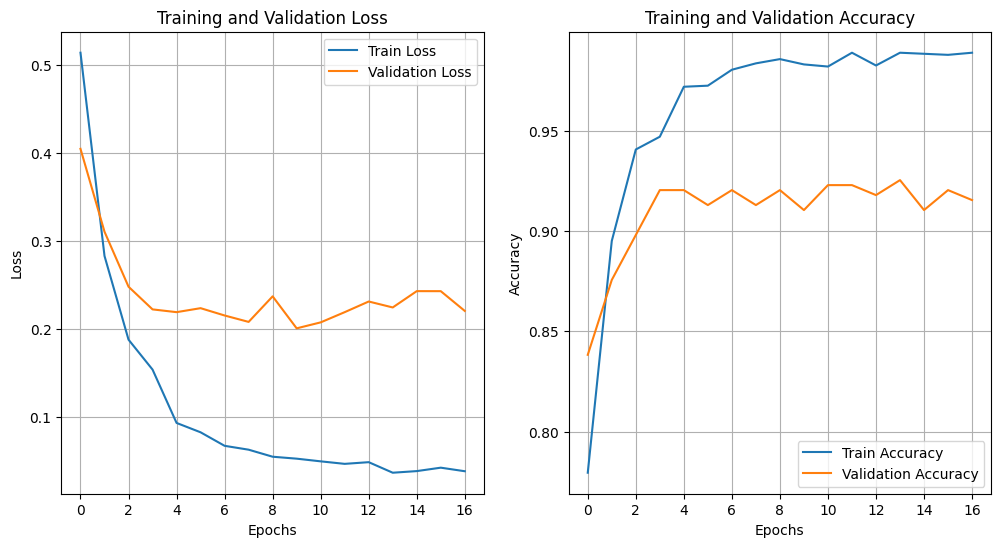

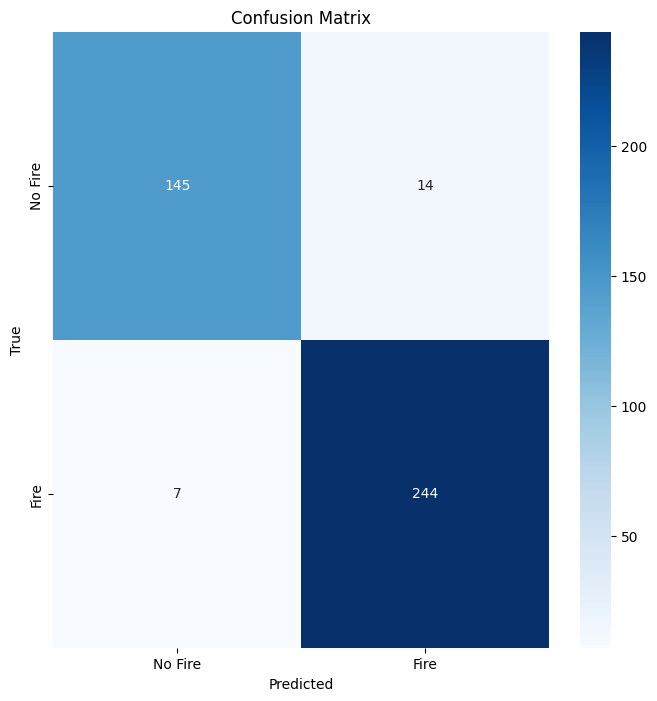

In [11]:
# Evaluation and Visualization
print("[INFO] Evaluating final model...")
metrics = evaluate_model(final_model, test_loader, ["No Fire", "Fire"], device)
# Training and Validation Curves
plot_training(history, f"outputs/efficientnet_baseline_training_curve.png")

# Confusion Matrix
plot_confusion_matrix(
    cm=metrics["confusion_matrix"],
    classes=["No Fire", "Fire"],
    output_path=f"outputs/efficientnet_baseline_confusion_matrix.png"
)

# Precision-Recall Curve
if "y_probs" in metrics:
    y_true = metrics["y_true"]
    y_probs = [prob[1] for prob in metrics["y_probs"]]
    plot_precision_recall(
        y_true=y_true,
        y_scores=y_probs,
        output_path=f"outputs/efficientnet_baseline_precision_recall_curve.png"
    )

    # ROC Curve
    plot_roc_curve(
        y_true=y_true,
        y_scores=y_probs,
        output_path=f"outputs/efficientnet_baseline_roc_curve.png"
    )

print("[INFO] All results saved successfully!")